# 1. Import Libraries

In [2]:
import torch
import evaluate
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from transformers import (
  T5TokenizerFast as T5Tokenizer,
  T5ForConditionalGeneration,
  Seq2SeqTrainingArguments,
  Seq2SeqTrainer,
  DataCollatorForSeq2Seq
)

from datasets import load_dataset, concatenate_datasets
from peft import LoraConfig, get_peft_model

# 2. Import Datasets

In [3]:
TOTAL_SAMPLES = 4000
MAX_INPUT_LENGTH = 512
VAL_SIZE = 0.1
TEST_SIZE = 0.1

def clean_text(text):
  if not text:
    return ""
  text = re.sub(r'\s+([.,!?%:])', r'\1', text)
  return " ".join(text.split())

def filter_and_process(dataset, text_key, summary_key, style_name):
  def process_example(example):
    t_clean = clean_text(example[text_key])
    s_clean = clean_text(example[summary_key])
    
    if style_name == "Detailed":
      s_clean = clean_text(example[summary_key].lstrip('-–—').strip())
      
    return {
      'text': t_clean,
      'summary': s_clean,
      'prompt': f"Summarize {style_name}: {t_clean}",
      'word_count': len(t_clean.split())
    }

  processed_ds = dataset.map(process_example, remove_columns=dataset.column_names)
  filtered_ds = processed_ds.filter(lambda x: 0 < x['word_count'] <= MAX_INPUT_LENGTH)
  
  return filtered_ds.select(range(min(TOTAL_SAMPLES, len(filtered_ds))))

xsum_raw = load_dataset('xsum', trust_remote_code=True, split='train')
cnn_raw = load_dataset('cnn_dailymail', '3.0.0', split='train')
multi_raw = load_dataset('multi_news', trust_remote_code=True, split='train')

harsh_ds = filter_and_process(xsum_raw, 'document', 'summary', 'Harsh')
balanced_ds = filter_and_process(cnn_raw, 'article', 'highlights', 'Balanced')
detailed_ds = filter_and_process(multi_raw, 'document', 'summary', 'Detailed')

dataset = concatenate_datasets([harsh_ds, balanced_ds, detailed_ds])

train_temp_split = dataset.train_test_split(test_size=TEST_SIZE + VAL_SIZE, shuffle=True, seed=42)
train_ds = train_temp_split['train']
temp_ds = train_temp_split['test']

val_test_split = temp_ds.train_test_split(test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE), shuffle=True, seed=42)
val_ds = val_test_split['train']
test_ds = val_test_split['test']

print(f"Train Size: {len(train_ds)}")
print(f"Validation Size: {len(val_ds)}")
print(f"Test Size: {len(test_ds)}")

Train Size: 9600
Validation Size: 1200
Test Size: 1200


# 3. Configurations & Parameters

In [4]:
MODEL_NAME = 'google/flan-t5-base'
OUT_DIRECTORY = 'results'
MAX_TARGET_LENGTH = 256
BATCH_SIZE = 4
MAX_EPOCHS = 5
GRADIENT_ACCUMULATION_STEPS = 2
LEARNING_RATE = 5e-4
SEED = 42

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)

rouge = evaluate.load("rouge")

# 4. Dataset Tokenization

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
  model_inputs = tokenizer(
    examples["prompt"],
    max_length=MAX_INPUT_LENGTH,
    truncation=True,
    padding="max_length",
  )
  labels = tokenizer(
    text_target=examples["summary"],
    max_length=MAX_TARGET_LENGTH,
    truncation=True,
    padding="max_length"
  )
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_valid = val_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

# 5. Model Initialization & Training

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

lora_config = LoraConfig(
  r=32,
  lora_alpha=64,
  target_modules=["q", "k", "v", "o"],
  lora_dropout=0.05,
  bias="none",
  task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model Loaded to {str(device).upper()}")

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} Total Parameters")

Model Loaded to CUDA
254,655,744 Total Parameters
7,077,888 Total Trainable Parameters


In [8]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)

  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  return {k: round(v, 4) for k, v in result.items()}

In [9]:
training_args = Seq2SeqTrainingArguments(
  output_dir=OUT_DIRECTORY,

  num_train_epochs=MAX_EPOCHS,
  learning_rate=LEARNING_RATE,
  per_device_train_batch_size=BATCH_SIZE,
  per_device_eval_batch_size=BATCH_SIZE,
  gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
  weight_decay=0.01,
  warmup_ratio=0.05,

  logging_steps=100,
  eval_strategy="steps",
  eval_steps=1000,
  save_strategy="steps",
  save_steps=1000,
  save_total_limit=2,
  load_best_model_at_end=True,

  fp16=False,
  bf16=True,
  predict_with_generate=True,
  generation_max_length=MAX_TARGET_LENGTH,
  report_to="none"
)

trainer = Seq2SeqTrainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_train,
  eval_dataset=tokenized_valid,
  data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
  compute_metrics=compute_metrics
)

history = trainer.train()

trainer.save_model(OUT_DIRECTORY)
tokenizer.save_pretrained(OUT_DIRECTORY)

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1000,0.870200,0.787769,0.382000,0.154100,0.271400,0.271500
2000,0.884700,0.785018,0.388100,0.156300,0.274500,0.274600
3000,0.863700,0.787379,0.390900,0.158700,0.275300,0.275200
4000,0.841700,0.786019,0.392000,0.160800,0.275600,0.275600
5000,0.833000,0.782791,0.391000,0.159900,0.276400,0.276400
6000,0.839600,0.782432,0.392500,0.160800,0.277600,0.277600


# 6. Model Evaluation

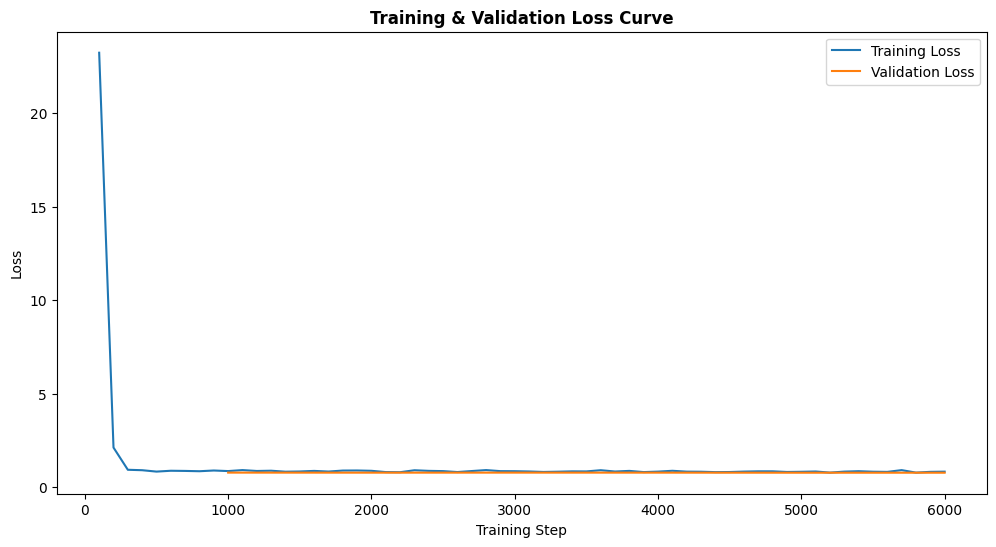

In [10]:
logs = trainer.state.log_history
logs_df = pd.DataFrame(logs)

train_loss = logs_df[logs_df["loss"].notna()][["step", "loss"]]
eval_loss = logs_df[logs_df["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(12, 6))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve", fontweight='bold')
plt.show()

In [11]:
val_metrics = trainer.evaluate()
test_metrics = trainer.evaluate(eval_dataset=tokenized_test, metric_key_prefix="test")

print(f"Val ROUGE-1: {val_metrics.get('eval_rouge1'):.4f}")
print(f"Val ROUGE-2: {val_metrics.get('eval_rouge2'):.4f}")
print(f"Val ROUGE-L: {val_metrics.get('eval_rougeL'):.4f}")
print(f"Val ROUGE-L Summary: {val_metrics.get('eval_rougeLsum'):.4f}")
print(f"Test ROUGE-1: {test_metrics.get('test_rouge1'):.4f}")
print(f"Test ROUGE-2: {test_metrics.get('test_rouge2'):.4f}")
print(f"Test ROUGE-L: {test_metrics.get('test_rougeL'):.4f}")
print(f"Test ROUGE-L Summary: {test_metrics.get('test_rougeLsum'):.4f}")

Val ROUGE-1: 0.3925
Val ROUGE-2: 0.1608
Val ROUGE-L: 0.2776
Val ROUGE-L Summary: 0.2776
Test ROUGE-1: 0.3872
Test ROUGE-2: 0.1592
Test ROUGE-L: 0.2749
Test ROUGE-L Summary: 0.2750


In [12]:
def generate_summary(text, style, model, tokenizer):
  model.eval()
  style_query = style.lower()
  input_text = f"Summarize {style_query}: {text}"
  input_words = len(text.split())

  inputs = tokenizer(
    input_text,
    max_length=512,
    truncation=True,
    return_tensors='pt'
  ).to(device)

  if style_query == 'harsh':
    max_len = int(input_words * 0.35)
    min_len = 5
    rep_penalty = 2.5
    length_penalty = 1.5
    beam_size = 4
    max_cap = 120
  elif style_query == 'balanced':
    max_len = int(input_words * 0.50)
    min_len = 20
    rep_penalty = 1.5
    length_penalty = 1.2
    beam_size = 4
    max_cap = 180
  else:
    max_len = int(input_words * 0.70)
    min_len = 50
    rep_penalty = 1.2
    length_penalty = 0.8
    beam_size = 4
    max_cap = 256

  max_len = min(max_len, max_cap)

  with torch.no_grad():
    outputs = model.generate(
      input_ids=inputs['input_ids'],
      attention_mask=inputs['attention_mask'],
      max_length=max_len,
      min_length=min_len,
      num_beams=beam_size,
      length_penalty=length_penalty,
      repetition_penalty=rep_penalty,
      no_repeat_ngram_size=3,
      early_stopping=True
    )

  return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [13]:
# Text Reference: https://www.nbcnews.com/tech/tech-news/openai-disney-sora-ai-videos-rcna248617
text = '''
  The Walt Disney Co. announced Thursday that it had reached a three-year agreement with OpenAI to bring its popular characters to the company's Sora artificial intelligence video generator.
  Disney will also make a $1 billion investment in OpenAI, the owner of ChatGPT. It said it will become a “major customer” of OpenAI, using its services to develop new products and experiences, including for its Disney+ streaming service.
  “Under the agreement, Disney and OpenAI are affirming a shared commitment to the responsible use of AI that protects user safety and the rights of creators,” the companies said in a statement.
  They did not disclose the terms of the deal, and both Disney CEO Bob Iger and OpenAI CEO Sam Altman declined to reveal any details Thursday morning during a joint interview on CNBC.
  OpenAI, meanwhile, said it has committed to “implementing responsible measures to further address trust and safety, including age-appropriate policies,” but did not provide additional details about what that would entail.
  The issue of how AI chatbots engage with users under 18 is the subject of a national conversation and several lawsuits.
  Disney said characters that are part of the deal include: Mickey Mouse, Minnie Mouse, Lilo, Stitch, Ariel, Belle, Beast, Cinderella, Baymax, Simba and Mufasa, as well as characters from the worlds of “Encanto,” “Frozen,” “Inside Out,” “Moana,” “Monsters Inc.,” “Toy Story,” “Up” and “Zootopia.”
  On CNBC, Iger described the deal broadly as "kind of a way" for Disney to get into AI.
  The deal is notable in part because Disney is famously protective of its sprawling portfolio of intellectual property, from the animated shorts of the 1920s to modern superhero and fantasy franchises.
  Altman said, "We hear so much from users about how much they love Disney," adding that he expects Sora users to respond "very well" to the inclusion of Disney characters.
  The companies do not yet have a launch date yet, however, Altman said. "We'll try to get it in there as soon as we can."
  The company's statement had mentioned "early 2026" as a potential launch date.
  Iger said in a statement, “Bringing together Disney’s iconic stories and characters with OpenAI’s groundbreaking technology puts imagination and creativity directly into the hands of Disney fans in ways we’ve never seen before, giving them richer and more personal ways to connect with the Disney characters and stories they love."
  Media companies are wrestling with how to secure the value of their intellectual property while not being left behind by what many see as a transformative technology with few legal guardrails yet.
  With OpenAI, Disney would be creating a legitimate avenue through which a generative AI program could deploy its characters, rather than playing whack-a-mole with every AI company, as Disney has done with other kinds of media in the past.
'''

print(f"Original Word Count: {len(text.split())}")
print("-" * 50)

harsh_summary = generate_summary(text, "Harsh", model, tokenizer)
print(f"\n=== Harsh (Words: {len(harsh_summary.split())}) ===\n{harsh_summary}")

balanced_summary = generate_summary(text, "Balanced", model, tokenizer)
print(f"\n=== Balanced (Words: {len(balanced_summary.split())}) ===\n{balanced_summary}")

detailed_summary = generate_summary(text, "Detailed", model, tokenizer)
print(f"\n=== Detailed (Words: {len(detailed_summary.split())}) ===\n{detailed_summary}")

Original Word Count: 464
--------------------------------------------------

=== Harsh (Words: 24) ===
The Walt Disney Co. has reached a three-year agreement with OpenAI to bring its popular characters to the company's Sora artificial intelligence video generator.

=== Balanced (Words: 56) ===
Walt Disney announces three-year agreement with OpenAI to bring its popular characters to Sora. Disney will also make a $1 billion investment in OpenAI, the owner of ChatGPT. Disney says it will become a "major customer" of OpenAI. The deal is notable in part because Disney is famously protective of its sprawling portfolio of intellectual property.

=== Detailed (Words: 130) ===
The Walt Disney Co. has reached a three-year agreement with OpenAI to bring its popular characters to the company's Sora artificial intelligence video generator, reports CNBC. "Under the agreement, Disney and OpenAI are affirming a shared commitment to the responsible use of AI that protects user safety and the rights of 